In [2]:
%config IPCompleter.greedy=True
import findspark
findspark.init()
from pyspark import SparkConf
from pyspark import SparkContext
from pyspark.sql import SparkSession
import socket

In [3]:
from sklearn.preprocessing import MultiLabelBinarizer

from pyspark.sql.types import *
from pyspark.sql import Window
from pyspark.sql import functions as f


from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline


from pyspark.sql import SparkSession

import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql.functions import col

from pyspark.sql import SparkSession
from pyspark.mllib.recommendation import ALS
from pyspark import SparkConf,SparkContext

In [4]:
conf = SparkConf() \
    .setAppName("ALSExample") \
    .setMaster("local[*]") \
    .set("spark.executor.memory", "10g") \
    .set("spark.driver.memory", "10g")

sc = SparkContext(conf=conf)
spark = SparkSession(sc)
computer_info = (socket.gethostname(), socket.gethostbyname(socket.gethostname()), conf.getAll())

print("Bilgisayar Adı:", computer_info[0])
print("IP Adresi:", computer_info[1])
print("Yapılandırma:", computer_info[2])

Bilgisayar Adı: ilker
IP Adresi: 192.168.1.16
Yapılandırma: [('spark.app.name', 'ALSExample'), ('spark.master', 'local[*]'), ('spark.executor.memory', '10g'), ('spark.driver.memory', '10g')]


In [5]:
spark = SparkSession.builder \
    .appName("Anime Recommendation System") \
    .getOrCreate()

In [5]:
anime_df = spark.read.csv("C:/Users/ilker/Desktop/Anime/anime.csv", header=True, inferSchema=True)
animelist_df = spark.read.csv("C:/Users/ilker/Desktop/Anime/animelist.csv", header=True, inferSchema=True)
print("Number of Animes:", anime_df.count())
anime_rdd = anime_df.rdd
anime_fields = anime_rdd.map(lambda row: "|".join([str(item) for item in row]))
print(anime_fields.first())
score_df = anime_df.select("Score")
score_df.show()

Number of Animes: 17562
1|Cowboy Bebop|8.78|Action, Adventure, Comedy, Drama, Sci-Fi, Space|Cowboy Bebop|カウボーイビバップ|TV|26|Apr 3, 1998 to Apr 24, 1999|Spring 1998|Bandai Visual|Funimation, Bandai Entertainment|Sunrise|Original|24 min. per ep.|R - 17+ (violence & profanity)|28.0|39|1251960.0|61971|105808|718161|71513|26678|329800|229170.0|182126.0|131625.0|62330.0|20688.0|8904.0|3184.0|1357.0|741.0|1580.0
+-----+
|Score|
+-----+
| 8.78|
| 8.39|
| 8.24|
| 7.27|
| 6.98|
| 7.95|
| 8.06|
| 7.59|
| 8.15|
| 8.76|
| 7.91|
| 8.52|
|  7.9|
| 6.38|
| 7.94|
| 7.42|
| 7.76|
| 7.32|
| 7.95|
| 7.51|
+-----+
only showing top 20 rows



<h1 style="color:blue">Null check</h1>


In [6]:
from pyspark.sql.functions import col, when, mean
from pyspark.sql.types import IntegerType, DoubleType, StringType
def replace_unknown(df):
    for column in df.columns:
        data_type = df.schema[column].dataType
        
        if isinstance(data_type, (IntegerType, DoubleType)):
            df = df.withColumn(column, when(col(column) == 'Unknown', None).otherwise(col(column).cast(data_type)))
            mean_value = df.select(mean(col(column))).collect()[0][0]
            df = df.na.fill({column: mean_value})
        elif isinstance(data_type, StringType):
            df = df.withColumn(column, when(col(column) == 'Unknown', '0').otherwise(col(column)))
    
    return df


anime_df = replace_unknown(anime_df)
animelist_df=replace_unknown(animelist_df)

In [7]:
def check_unknown_values(df):
    for column in df.columns:
        unknown_count = df.filter(col(column) == 'Unknown').count()
        if unknown_count > 0:
            print(f"Column '{column}' has {unknown_count} 'unknown' values.")
        else:
            print(f"Column '{column}' has no 'unknown' values.")


print("Checking 'anime_list_df' for 'unknown' values:")
check_unknown_values(animelist_df)


print("\nChecking 'anime_df' for 'unknown' values:")
check_unknown_values(anime_df)

Checking 'anime_list_df' for 'unknown' values:
Column 'user_id' has no 'unknown' values.
Column 'anime_id' has no 'unknown' values.
Column 'rating' has no 'unknown' values.
Column 'watching_status' has no 'unknown' values.
Column 'watched_episodes' has no 'unknown' values.

Checking 'anime_df' for 'unknown' values:
Column 'MAL_ID' has no 'unknown' values.
Column 'Name' has no 'unknown' values.
Column 'Score' has no 'unknown' values.
Column 'Genres' has no 'unknown' values.
Column 'English name' has no 'unknown' values.
Column 'Japanese name' has no 'unknown' values.
Column 'Type' has no 'unknown' values.
Column 'Episodes' has no 'unknown' values.
Column 'Aired' has no 'unknown' values.
Column 'Premiered' has no 'unknown' values.
Column 'Producers' has no 'unknown' values.
Column 'Licensors' has no 'unknown' values.
Column 'Studios' has no 'unknown' values.
Column 'Source' has no 'unknown' values.
Column 'Duration' has no 'unknown' values.
Column 'Rating' has no 'unknown' values.
Column

<h1 style="color:blue">Empty check</h1>

In [8]:
def check_null_empty_values(df):
    for column in df.columns:
        null_count = df.filter(col(column).isNull()).count()
        empty_count = df.filter(col(column) == '').count()
        total_null_empty_count = null_count + empty_count
        if total_null_empty_count > 0:
            print(f"Column '{column}' has {null_count} null values and {empty_count} empty values.")
        else:
            print(f"Column '{column}' has no null or empty values.")

print("\nChecking for null or empty values in 'anime_list_df':")
check_null_empty_values(animelist_df)


print("\nChecking for null or empty values in 'anime_df':")
check_null_empty_values(anime_df)


Checking for null or empty values in 'anime_list_df':
Column 'user_id' has no null or empty values.
Column 'anime_id' has no null or empty values.
Column 'rating' has no null or empty values.
Column 'watching_status' has no null or empty values.
Column 'watched_episodes' has no null or empty values.

Checking for null or empty values in 'anime_df':
Column 'MAL_ID' has no null or empty values.
Column 'Name' has no null or empty values.
Column 'Score' has no null or empty values.
Column 'Genres' has no null or empty values.
Column 'English name' has no null or empty values.
Column 'Japanese name' has no null or empty values.
Column 'Type' has no null or empty values.
Column 'Episodes' has no null or empty values.
Column 'Aired' has no null or empty values.
Column 'Premiered' has no null or empty values.
Column 'Producers' has no null or empty values.
Column 'Licensors' has no null or empty values.
Column 'Studios' has no null or empty values.
Column 'Source' has no null or empty values.

<h1 style="color:red">Calculation Age of Anime</h1>

In [9]:
import re

def check_aired_date_format(df, column_name):
    date_pattern = r'^\w{3}\s\d{1,2},\s\d{4}\sto\s\w{3}\s\d{1,2},\s\d{4}$'
    
    invalid_dates = df.filter(~col(column_name).rlike(date_pattern)).count()
    
    if invalid_dates > 0:
        print(f"Column '{column_name}' contains {invalid_dates} entries with invalid date format.")
    else:
        print(f"All entries in column '{column_name}' have valid date format.")

check_aired_date_format(anime_df, "Aired")

Column 'Aired' contains 9825 entries with invalid date format.


In [10]:
from pyspark.sql.functions import udf
from pyspark.sql.functions import col, lit, regexp_extract, when, expr, udf
from pyspark.sql.types import StringType
import re

date_pattern = r'(\w{3}\s\d{1,2},\s\d{4})\s?(?:to\s(\w{3}\s\d{1,2},\s\d{4}))?'

# Function to process aired dates
def process_aired_dates(row):
    aired_date = row['Aired']
    match = re.match(date_pattern, aired_date)
    if match:
        start_date = match.group(1)
        end_date = match.group(2)
    else:
        start_date = ''
        end_date = ''
    if start_date == '':
        start_date = 'Jan 1, 1900'
    if end_date == '':
        end_date = 'Dec 31, 2024'
    return (start_date, end_date)

# Define the User Defined Function (UDF) for processing aired dates
process_aired_udf = udf(process_aired_dates, StringType())

# Process the 'Aired' column and add new columns for start and end dates
anime_df = anime_df.withColumn("Start_Date", regexp_extract(col("Aired"), date_pattern, 1)) \
                   .withColumn("End_Date", regexp_extract(col("Aired"), date_pattern, 2))

# Fill missing values
anime_df = anime_df.withColumn("Start_Date", when(col("Start_Date") == "", lit("Jan 1, 1900")).otherwise(col("Start_Date"))) \
                   .withColumn("End_Date", when(col("End_Date") == "", lit("Dec 31, 2024")).otherwise(col("End_Date")))

anime_df = anime_df.withColumn("Start_Year", expr("substring(Start_Date, -4)")) \
                   .withColumn("End_Year", expr("substring(End_Date, -4)")) \
                   .withColumn("Duration", col("End_Year").cast("int") - col("Start_Year").cast("int"))

# Sonuçları göster
anime_df.select("Aired", "Start_Date", "End_Date", "Duration").show(truncate=False)


+----------------------------+------------+------------+--------+
|Aired                       |Start_Date  |End_Date    |Duration|
+----------------------------+------------+------------+--------+
|Apr 3, 1998 to Apr 24, 1999 |Apr 3, 1998 |Apr 24, 1999|1       |
|Sep 1, 2001                 |Sep 1, 2001 |Dec 31, 2024|23      |
|Apr 1, 1998 to Sep 30, 1998 |Apr 1, 1998 |Sep 30, 1998|0       |
|Jul 2, 2002 to Dec 24, 2002 |Jul 2, 2002 |Dec 24, 2002|0       |
|Sep 30, 2004 to Sep 29, 2005|Sep 30, 2004|Sep 29, 2005|1       |
|Apr 6, 2005 to Mar 19, 2008 |Apr 6, 2005 |Mar 19, 2008|3       |
|Apr 15, 2005 to Sep 27, 2005|Apr 15, 2005|Sep 27, 2005|0       |
|Sep 11, 2002 to Sep 10, 2003|Sep 11, 2002|Sep 10, 2003|1       |
|Apr 17, 2004 to Feb 18, 2006|Apr 17, 2004|Feb 18, 2006|2       |
|Apr 7, 2004 to Sep 28, 2005 |Apr 7, 2004 |Sep 28, 2005|1       |
|Oct 3, 2002 to Feb 8, 2007  |Oct 3, 2002 |Feb 8, 2007 |5       |
|Oct 20, 1999 to ?           |Oct 20, 1999|Dec 31, 2024|25      |
|Oct 10, 2

In [11]:

def check_missing_dates(df):

    missing_start_dates = df.filter(col("Start_Date") == "").count()

    missing_end_dates = df.filter(col("End_Date") == "").count()
    

    if missing_start_dates > 0:
        print(f"{missing_start_dates} entries with missing start dates.")
    if missing_end_dates > 0:
        print(f"{missing_end_dates} entries with missing end dates.")
    if missing_start_dates == 0 and missing_end_dates == 0:
        print("No missing start or end dates.")


check_missing_dates(anime_df)


No missing start or end dates.


In [12]:

movie_ages = anime_df.select("Start_Year").rdd.map(lambda row: 2024 - int(row["Start_Year"])).countByValue()

values = list(movie_ages.values())
bins = list(movie_ages.keys())

print("Ages:", bins)
print("Frequencies:", values)

Ages: [26, 23, 22, 20, 19, 25, 21, 29, 27, 28, 36, 31, 24, 45, 35, 33, 39, 38, 30, 32, 34, 46, 51, 18, 37, 40, 42, 47, 41, 44, 48, 56, 43, 124, 17, 53, 57, 49, 62, 59, 55, 50, 60, 16, 52, 54, 58, 61, 79, 15, 12, 91, 81, 14, 93, 92, 90, 64, 66, 13, 65, 77, 95, 107, 94, 88, 89, 86, 67, 106, 97, 96, 87, 84, 80, 69, 68, 63, 8, 11, 5, 83, 10, 9, 7, 6, 82, 98, 76, 3, 4, 2]
Frequencies: [199, 319, 314, 337, 360, 213, 326, 173, 181, 189, 145, 178, 197, 66, 173, 176, 111, 128, 182, 193, 184, 49, 26, 417, 149, 90, 80, 41, 86, 65, 38, 26, 82, 2099, 432, 30, 25, 32, 9, 19, 30, 33, 14, 429, 23, 34, 23, 10, 1, 507, 672, 8, 4, 511, 4, 2, 9, 2, 3, 615, 4, 2, 4, 11, 4, 1, 7, 2, 3, 7, 2, 2, 1, 3, 1, 1, 1, 4, 874, 685, 724, 1, 822, 772, 904, 872, 2, 1, 1, 168, 602, 1]


[  2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19
  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37
  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55
  56  57  58  59  60  61  62  63  64  65  66  67  68  69  76  77  79  80
  81  82  83  84  86  87  88  89  90  91  92  93  94  95  96  97  98 106
 107 124]


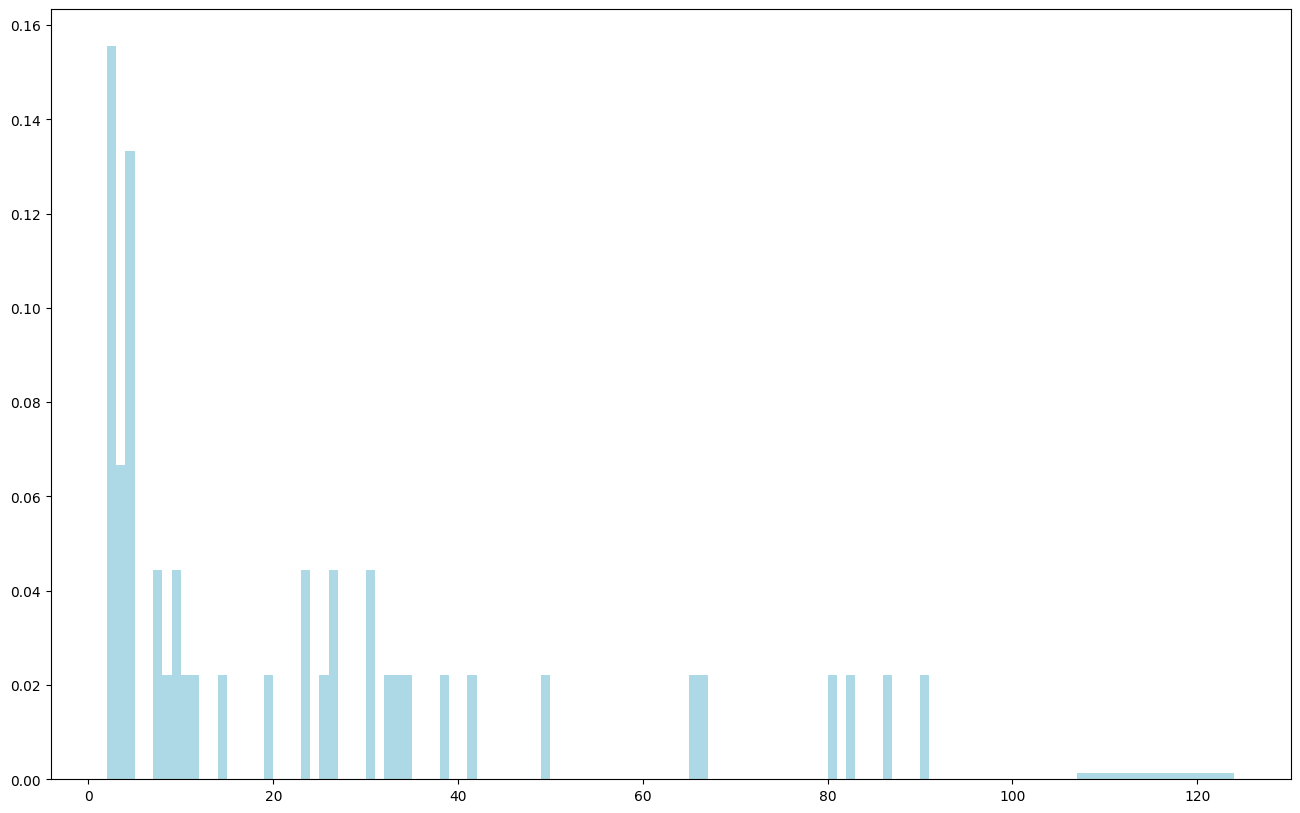

In [13]:
import matplotlib.pyplot as plt
import numpy as np
bins = np.sort(bins)
print(bins)
plt.hist(values, bins=bins, color='lightblue', density=True)
fig = plt.gcf()
fig.set_size_inches(16, 10)

plt.show()


<h1 style="color:blue">Score</h1>


In [14]:
columns = score_df.columns
score_pd_df = score_df.toPandas()
values = score_pd_df.iloc[:, 0].tolist()
bins = columns
score_pd_df['Score'] = score_pd_df['Score'].replace('Unknown', 0)
values = score_pd_df['Score'].tolist()

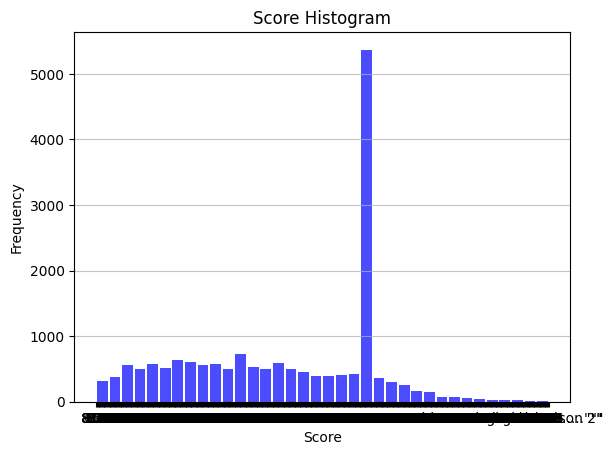

In [15]:
import matplotlib.pyplot as plt
plt.hist(values, bins='auto', color='blue', alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Score Histogram')
plt.show()


<h1 style="color:blue">Episodes</h1>

      Episodes
0           26
1            1
2           26
3           26
4           52
...        ...
17557        0
17558        0
17559        0
17560        0
17561        0

[17562 rows x 1 columns]


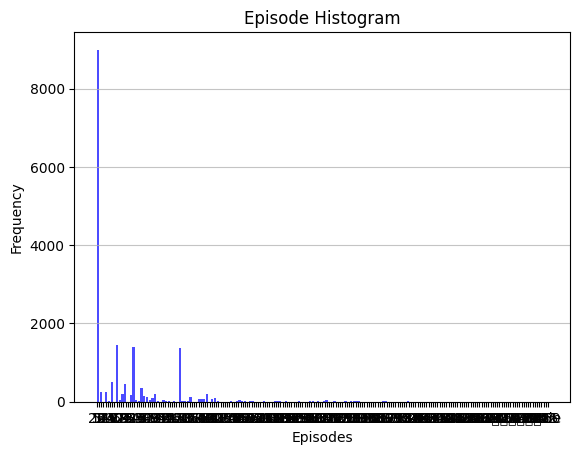

In [16]:
import warnings
warnings.filterwarnings("ignore")
episodes_df = anime_df.select("Episodes")
columns = episodes_df.columns
episodes_df = episodes_df.toPandas()
values = episodes_df.iloc[:, 0].tolist()
bins = columns
episodes_df['Episodes'] = episodes_df['Episodes'].replace('Unknown', 0)
print(episodes_df)
values = episodes_df['Episodes'].tolist()
plt.hist(values, bins='auto', color='blue', alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Episodes')
plt.ylabel('Frequency')
plt.title('Episode Histogram')
plt.show()

<h1 style="color:blue">Popularity</h1>

      Popularity
0             39
1            518
2            201
3           1467
4           4369
...          ...
17557      13116
17558      17562
17559      17558
17560      17565
17561      17563

[17562 rows x 1 columns]


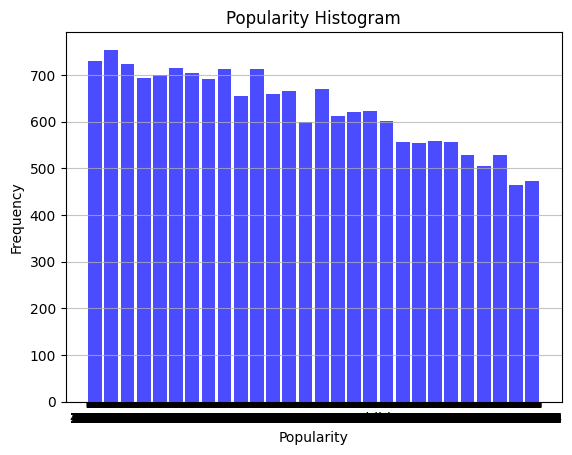

In [17]:
import warnings
warnings.filterwarnings("ignore")
episodes_df = anime_df.select("Popularity")
columns = episodes_df.columns
episodes_df = episodes_df.toPandas()
values = episodes_df.iloc[:, 0].tolist()
bins = columns
episodes_df['Popularity'] = episodes_df['Popularity'].replace('Unknown', 0)
print(episodes_df)
values = episodes_df['Popularity'].tolist()
plt.hist(values, bins='auto', color='blue', alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Popularity')
plt.ylabel('Frequency')
plt.title('Popularity Histogram')
plt.show()

<h1 style="color:blue">Type</h1>

In [18]:
type_rdd = anime_df.select("type").rdd.map(lambda row: (row['type'], 1))
type_counts = type_rdd.reduceByKey(lambda a, b: a + b)
result = type_counts.collect()
filtered_result = [item for item in result if re.match(r'^[a-zA-Z0-9\s]+$', item[0])]
for type, count in filtered_result:
    print(f"{type}: {count}")

TV: 4994
Movie: 3039
Special: 2218
ONA: 1907
0: 37
OVA: 3893
Music: 1469


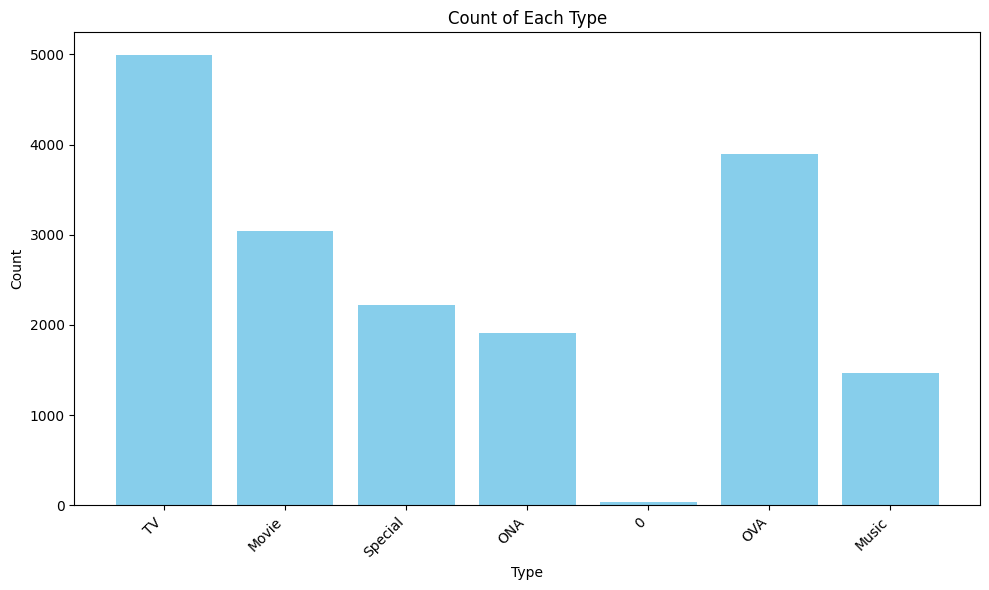

In [19]:
types = [item[0] for item in filtered_result]
counts = [item[1] for item in filtered_result]
plt.figure(figsize=(10, 6))
plt.bar(types, counts, color='skyblue')
plt.xlabel('Type')
plt.ylabel('Count')
plt.title('Count of Each Type')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

<h1 style="color:blue">launch age</h1>

In [22]:
anime_df = anime_df.withColumn("Premired Year", regexp_extract(col("Premiered"), r'(\d{4})', 1))

anime_df.show(5)
anime_df = anime_df.filter(col("Premired Year").cast("int").isNotNull())

current_year = 2024
ages_rdd = anime_df.select("Premired Year").rdd.map(lambda row: current_year - int(row["Premired Year"])).countByValue()

# Yaş verilerini almak
values = list(ages_rdd.values())
bins = list(ages_rdd.keys())

# Sonuçları yazdırma
print("Bins:", bins)
print("Values:", values)

+------+------------------+-----+--------------------+--------------------+--------------------+----+--------+--------------------+-----------+--------------------+--------------------+--------------+--------+--------+--------------------+------+----------+---------+---------+--------+---------+-------+-------+-------------+--------+--------+--------+-------+-------+-------+-------+-------+-------+-------+------------+------------+----------+--------+-------------+
|MAL_ID|              Name|Score|              Genres|        English name|       Japanese name|Type|Episodes|               Aired|  Premiered|           Producers|           Licensors|       Studios|  Source|Duration|              Rating|Ranked|Popularity|  Members|Favorites|Watching|Completed|On-Hold|Dropped|Plan to Watch|Score-10| Score-9| Score-8|Score-7|Score-6|Score-5|Score-4|Score-3|Score-2|Score-1|  Start_Date|    End_Date|Start_Year|End_Year|Premired Year|
+------+------------------+-----+--------------------+------

[ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26
 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50
 51 52 53 54 55 56 57 58 59 60 61 62 63 98]


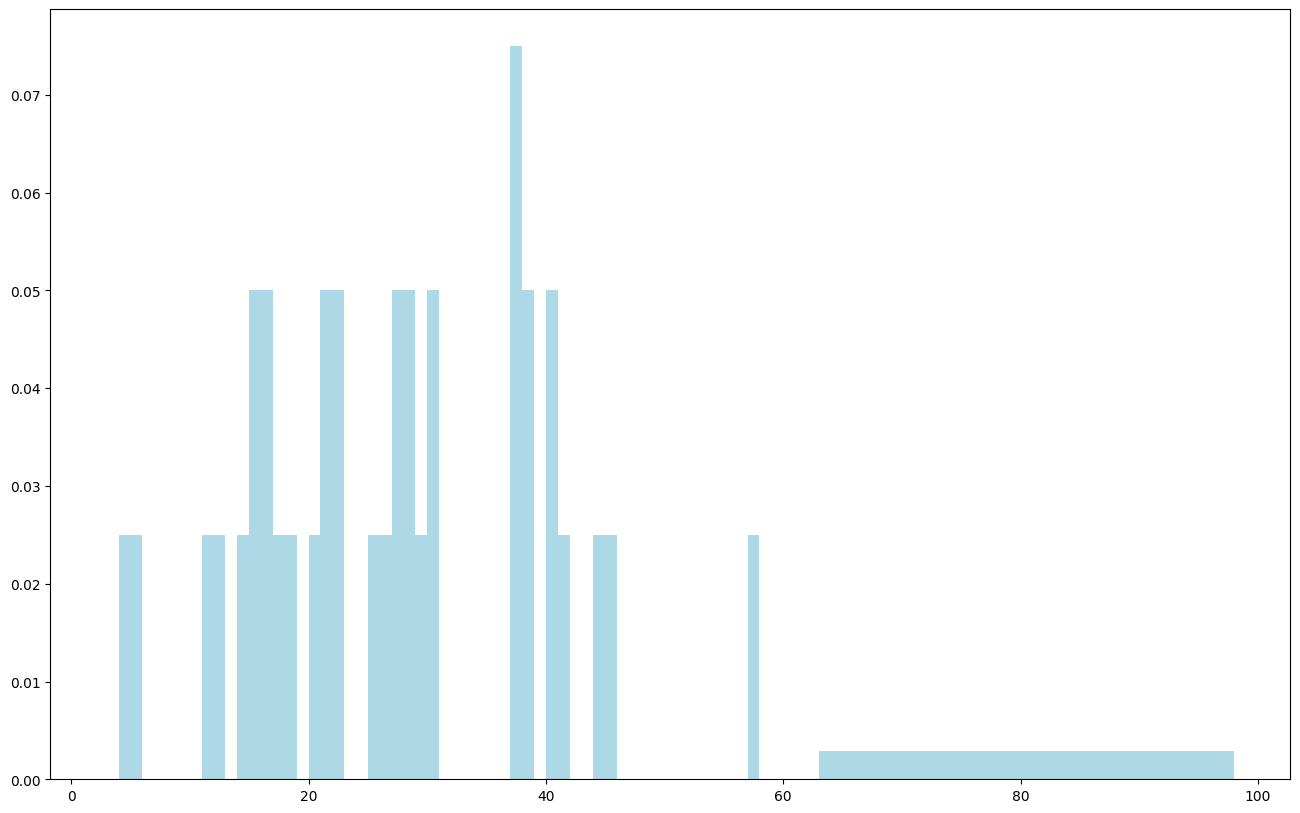

In [21]:
import matplotlib.pyplot as plt
import numpy as np
bins = np.sort(bins)
print(bins)
plt.hist(values, bins=bins, color='lightblue', density=True)
fig = plt.gcf()
fig.set_size_inches(16, 10)
plt.show()

<h1 style="color:blue">Ranked</h1>

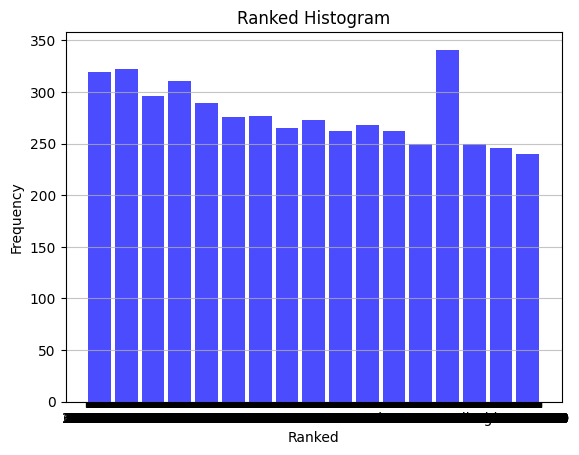

In [23]:
import warnings
warnings.filterwarnings("ignore")
episodes_df = anime_df.select("Ranked")
columns = episodes_df.columns
episodes_df = episodes_df.toPandas()
values = episodes_df.iloc[:, 0].tolist()
bins = columns
episodes_df['Ranked'] = episodes_df['Ranked'].replace('Unknown', 0)
values = episodes_df['Ranked'].tolist()
plt.hist(values, bins='auto', color='blue', alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Ranked')
plt.ylabel('Frequency')
plt.title('Ranked Histogram')
plt.show()

<h1 style="color:blue">Watching Status</h1>

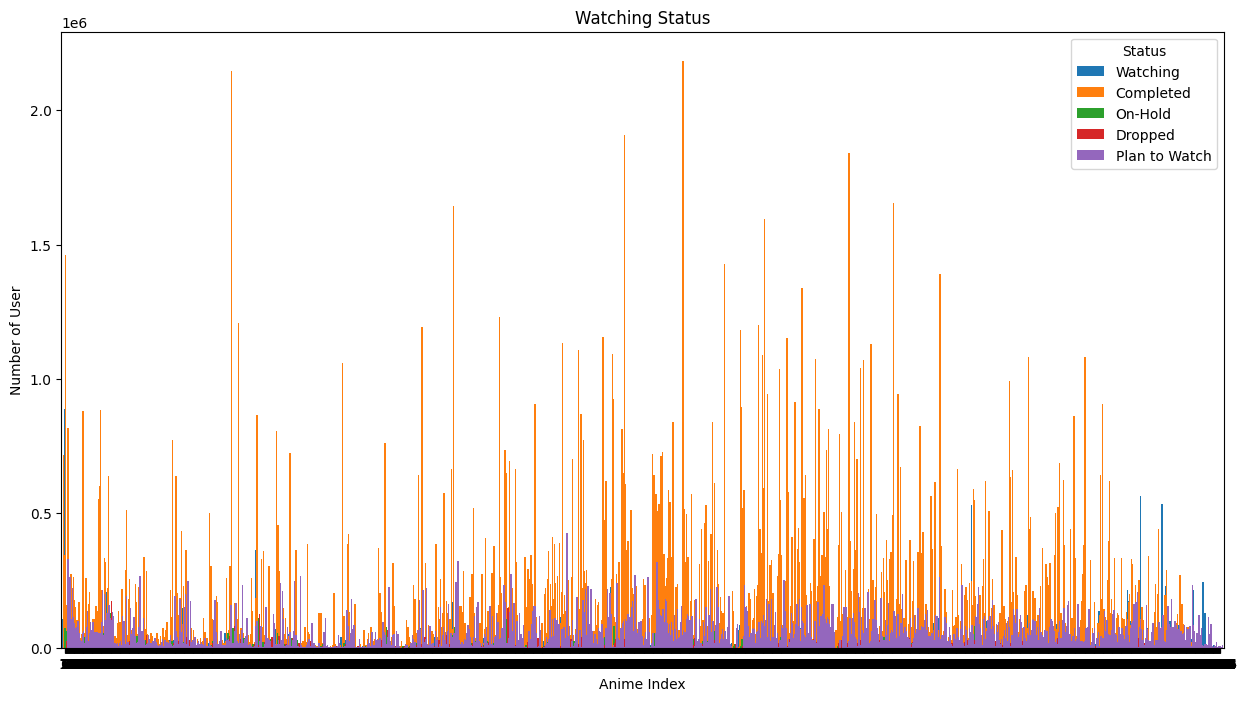

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
watching_list = anime_df.select("Watching").rdd.flatMap(lambda x: x).collect()
completed_list = anime_df.select("Completed").rdd.flatMap(lambda x: x).collect()
on_hold_list = anime_df.select("On-Hold").rdd.flatMap(lambda x: x).collect()
dropped_list = anime_df.select("Dropped").rdd.flatMap(lambda x: x).collect()
plan_to_watch_list = anime_df.select("Plan to Watch").rdd.flatMap(lambda x: x).collect()


data = {
    "Watching": watching_list,
    "Completed": completed_list,
    "On-Hold": on_hold_list,
    "Dropped": dropped_list,
    "Plan to Watch": plan_to_watch_list
}


df_prepared = pd.DataFrame(data)


bar_width = 30 
df_prepared.plot(kind='bar', figsize=(15, 8), width=bar_width)

plt.xlabel('Anime Index')
plt.ylabel('Number of User')
plt.title('Watching Status')
plt.xticks(rotation=0)
plt.legend(title='Status')
plt.show()

<h1 style="color:blue">Source</h1>

Original: 1159
Manga: 1442
Light novel: 354
Visual novel: 157
Novel: 132
0: 663
Radio: 5
Book: 37
Card game: 44
Digital manga: 8
CloverWorks: 1
Game: 266
Other: 161
Picture book: 63
Web manga: 93
Music: 16


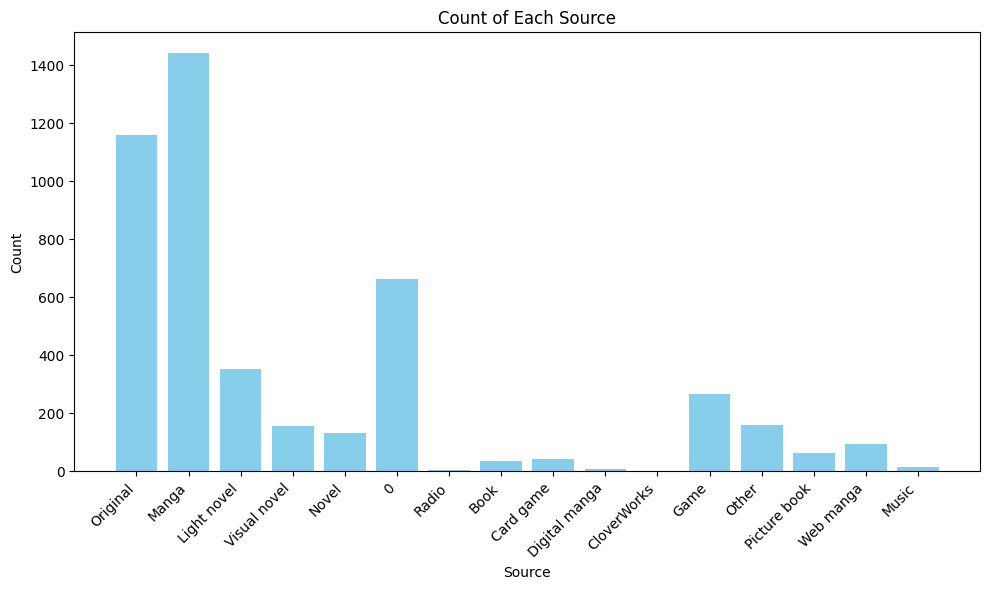

In [25]:
source_rdd = anime_df.select("Source").rdd.map(lambda row: (row['Source'], 1))
source_counts = source_rdd.reduceByKey(lambda a, b: a + b)
result = source_counts.collect()
filtered_result = [item for item in result if re.match(r'^[a-zA-Z0-9\s]+$', item[0])]
for type, count in filtered_result:
    print(f"{type}: {count}")

source = [item[0] for item in filtered_result]
counts = [item[1] for item in filtered_result]
plt.figure(figsize=(10, 6))
plt.bar(source, counts, color='skyblue')
plt.xlabel('Source')
plt.ylabel('Count')
plt.title('Count of Each Source')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

<h1 style="color:Violet">😺Genres😺</h1>

In [26]:
anime_df = anime_df.drop("English name", "Japanese name", "Producers", "Licensors", "Studios", "Duration", "Rating")

In [27]:
best_anime = anime_df\
            .filter('score is not null')\
            .withColumnRenamed('MAL_ID', 'anime_id')\
            .orderBy('score', ascending=False)\
            .cache()

best_anime.take(5)

[Row(anime_id=5114, Name='Fullmetal Alchemist: Brotherhood', Score='9.19', Genres='Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen', Type='TV', Episodes='64', Aired='Apr 5, 2009 to Jul 4, 2010', Premiered='Spring 2009', Source='Manga', Ranked='1.0', Popularity='3', Members=2248456.0, Favorites=183914, Watching=171871, Completed=1644938, On-Hold=75728, Dropped=32456, Plan to Watch=323463, Score-10='714811.0', Score-9='401507.0', Score-8='199160.0', Score-7='70045.0', Score-6='20210.0', Score-5='9308.0', Score-4='3222.0', Score-3='1536.0', Score-2='2162.0', Score-1='16806.0', Start_Date='Apr 5, 2009', End_Date='Jul 4, 2010', Start_Year='2009', End_Year='2010', Premired Year='2009'),
 Row(anime_id=40028, Name='Shingeki no Kyojin: The Final Season', Score='9.17', Genres='Action, Military, Mystery, Super Power, Drama, Fantasy, Shounen', Type='TV', Episodes='16', Aired='Dec 7, 2020 to ?', Premiered='Winter 2021', Source='Manga', Ranked='2.0', Popularity='119', Members=733

In [28]:
from pyspark.sql.types import *
from pyspark.sql import Window
from pyspark.sql import functions as f

popular_genres = anime_df.withColumn('genres_list', f.split('genres', ','))\
                     .withColumn('genre', f.explode('genres_list'))\
                     .groupBy('genre')\
                     .agg(f.count(f.col('name')).alias('genre_count'), f.avg(f.col('score')).alias('avg_score'))\
                     .orderBy('genre_count', ascending=False)\
                    .withColumn('pct_of_total', f.col('genre_count') / f.sum('genre_count').over(Window.partitionBy()))\
                    .withColumn('pct_of_total', f.col('pct_of_total') * 100)\
                    .cache()

popular_genres.show(10)

+----------+-----------+------------------+------------------+
|     genre|genre_count|         avg_score|      pct_of_total|
+----------+-----------+------------------+------------------+
|    Action|       1375| 6.409069090909091|  8.08585710085269|
|    Comedy|       1176| 6.052312925170063| 6.915613054983829|
|    Comedy|       1119| 4.978793565683646| 6.580417524257571|
|   Fantasy|        918| 5.946252723311546| 5.398412231696559|
|   Shounen|        856| 6.736273364485982|  5.03381358423993|
|   Romance|        766| 6.963198433420364| 4.504557483093208|
|    Sci-Fi|        748|6.2898930481283415| 4.398706262863864|
|    School|        734| 6.700149863760219| 4.316377536018818|
|     Drama|        711| 6.892039381153304|   4.1811231990591|
| Adventure|        563| 6.171669626998223|3.3107909438400474|
+----------+-----------+------------------+------------------+
only showing top 10 rows



In [29]:
#Pct_of_total adds up to 100% which is a sign that we've calculated this column correctly:
popular_genres.select(f.sum(popular_genres['pct_of_total']).alias('pct_sum')).show()

+-------+
|pct_sum|
+-------+
|  100.0|
+-------+



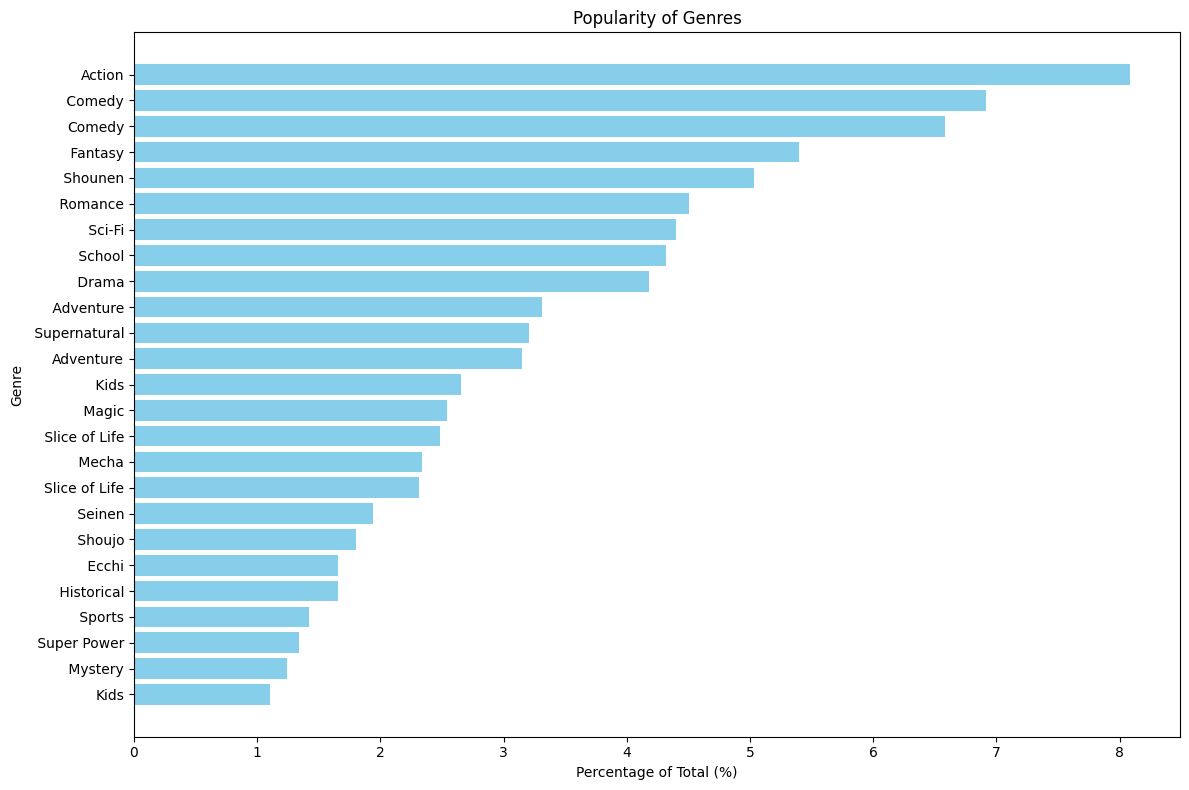

In [30]:
popular_genres_pd = popular_genres.toPandas()

top25_genres_pd = popular_genres_pd.head(25)


plt.figure(figsize=(12, 8))
plt.barh(top25_genres_pd['genre'], top25_genres_pd['pct_of_total'], color='skyblue')
plt.xlabel('Percentage of Total (%)')
plt.ylabel('Genre')
plt.title('Popularity of Genres')
plt.gca().invert_yaxis()  
plt.tight_layout()  
plt.show()

<h1 style="font-size:30px; color:red;"> 🎌Next CSV - Animelist🎌 </h1>

In [31]:
animelist_df = animelist_df.drop("Watching Status")

num_users = animelist_df.select("user_id").distinct().count()
num_anime = animelist_df.select("anime_id").distinct().count()
num_ratings = animelist_df.select("rating").distinct().count()


# Sonuçları yazdır
print('Number of Users: {}, Number of Anime: {}, Number of Ratings: {} '.format(num_users, num_anime, num_ratings))

Number of Users: 325770, Number of Anime: 17562, Number of Ratings: 11 


In [32]:
print("Number of Users' Rating:", animelist_df.count())
animelist_rdd = animelist_df.rdd
animelist_data = animelist_rdd.map(lambda row: "|".join([str(item) for item in row]))
print(animelist_data.first())
rating_df = animelist_df.select("Rating")
rating_df.show()

Number of Users' Rating: 109224747
0|67|9|1|1
+------+
|Rating|
+------+
|     9|
|     7|
|    10|
|     0|
|    10|
|     9|
|     0|
|     8|
|     6|
|     9|
|    10|
|     6|
|     6|
|     6|
|     7|
|     9|
|     9|
|     9|
|     7|
|    10|
+------+
only showing top 20 rows



In [33]:
animelist_rdd.take(5)

[Row(user_id=0, anime_id=67, rating=9, watching_status=1, watched_episodes=1),
 Row(user_id=0, anime_id=6702, rating=7, watching_status=1, watched_episodes=4),
 Row(user_id=0, anime_id=242, rating=10, watching_status=1, watched_episodes=4),
 Row(user_id=0, anime_id=4898, rating=0, watching_status=1, watched_episodes=1),
 Row(user_id=0, anime_id=21, rating=10, watching_status=1, watched_episodes=0)]

In [34]:
animelist_fields = animelist_data.map(lambda line: line.split('|'))

In [35]:
%%time

num_users = animelist_fields.map(lambda field : field[0]).distinct().count()

CPU times: total: 31.2 ms
Wall time: 2min 16s


In [36]:
%%time
num_anime = animelist_fields.map(lambda field : field[1]).distinct().count()

CPU times: total: 31.2 ms
Wall time: 2min 19s


In [37]:
%%time
num_rating = animelist_fields.map(lambda field : field[2]).count()

CPU times: total: 0 ns
Wall time: 1min 56s


In [38]:
%%time
num_watching = animelist_fields.map(lambda field : field[3]).distinct().count()

CPU times: total: 15.6 ms
Wall time: 2min 17s


In [39]:
%%time
num_episodes = animelist_fields.map(lambda field : field[4]).count()

CPU times: total: 31.2 ms
Wall time: 1min 54s


In [40]:
print('Number of Uniqu User:{}, Number of Uniqu Anime:{}, Number of Rating:{},Number of Unique Watching:{}, Number of Episodes:{}'.format(num_users,num_anime,
                                                                                                                    num_rating,num_watching,num_episodes))

Number of Uniqu User:325770, Number of Uniqu Anime:17562, Number of Rating:109224747,Number of Unique Watching:9, Number of Episodes:109224747


['user_id', 'anime_id', 'rating', 'watching_status', 'watched_episodes']
0|67|9|1|1
Veri kümesinde toplam satır sayısı: 109224747


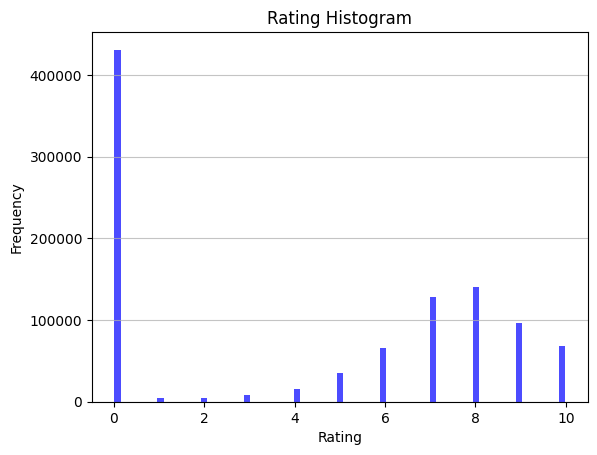

In [41]:
 anime_list_rdd = animelist_df.rdd
anime_list_fields = anime_list_rdd.map(lambda row: "|".join([str(item) for item in row]))
schema = animelist_df.schema
column_names = [field.name for field in schema]
print(column_names)
print(anime_list_fields.first())
import warnings
warnings.filterwarnings("ignore")
total_rows = animelist_df.count()
print("Veri kümesinde toplam satır sayısı:", total_rows)
animelist_df_first_10000 = animelist_df.limit(1000000)
rating_df = animelist_df_first_10000.select("Rating")

rating_df = rating_df.toPandas()
rating_df['Rating'] = rating_df['Rating'].replace('Unknown', 0)
values = rating_df['Rating'].tolist()
columns = rating_df.columns
plt.hist(values, bins='auto', color='blue', alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Rating Histogram')
plt.show()

In [42]:
anime_df = anime_df.withColumnRenamed('MAL_id', 'anime_id')
anime_df.show()
anime_df = anime_df.drop("Start_Date", "End_Date" )
son_data = anime_df.join(animelist_df, on=["anime_id"], how="inner")
son_data.show(15)

+--------+--------------------+-----+--------------------+----+--------+--------------------+-----------+-----------+------+----------+---------+---------+--------+---------+-------+-------+-------------+--------+--------+--------+--------+--------+-------+-------+-------+-------+-------+------------+------------+----------+--------+-------------+
|anime_id|                Name|Score|              Genres|Type|Episodes|               Aired|  Premiered|     Source|Ranked|Popularity|  Members|Favorites|Watching|Completed|On-Hold|Dropped|Plan to Watch|Score-10| Score-9| Score-8| Score-7| Score-6|Score-5|Score-4|Score-3|Score-2|Score-1|  Start_Date|    End_Date|Start_Year|End_Year|Premired Year|
+--------+--------------------+-----+--------------------+----+--------+--------------------+-----------+-----------+------+----------+---------+---------+--------+---------+-------+-------+-------------+--------+--------+--------+--------+--------+-------+-------+-------+-------+-------+-----------

In [43]:
from pyspark.sql.functions import col
rating_fields = son_data.select(col("user_id"), col("anime_id"), col("rating")).rdd.map(lambda row: "|".join([str(item) for item in row]))
ratings = son_data.select("rating").rdd.map(lambda row: int(row['rating']))
stats = ratings.stats()
print(stats)

(count: 74963444, mean: 4.287202412951999, stdev: 3.9441466964476537, max: 10.0, min: 0.0)


In [44]:
count_by_rating = ratings.countByValue()
x_axis = list(count_by_rating.keys())
y_axis = list(count_by_rating.values())
y_axis_normed = np.array(y_axis) / sum(y_axis)
sorted_indices = np.argsort(x_axis)
x_axis_sorted = np.array(x_axis)[sorted_indices]
y_axis_sorted = y_axis_normed[sorted_indices]

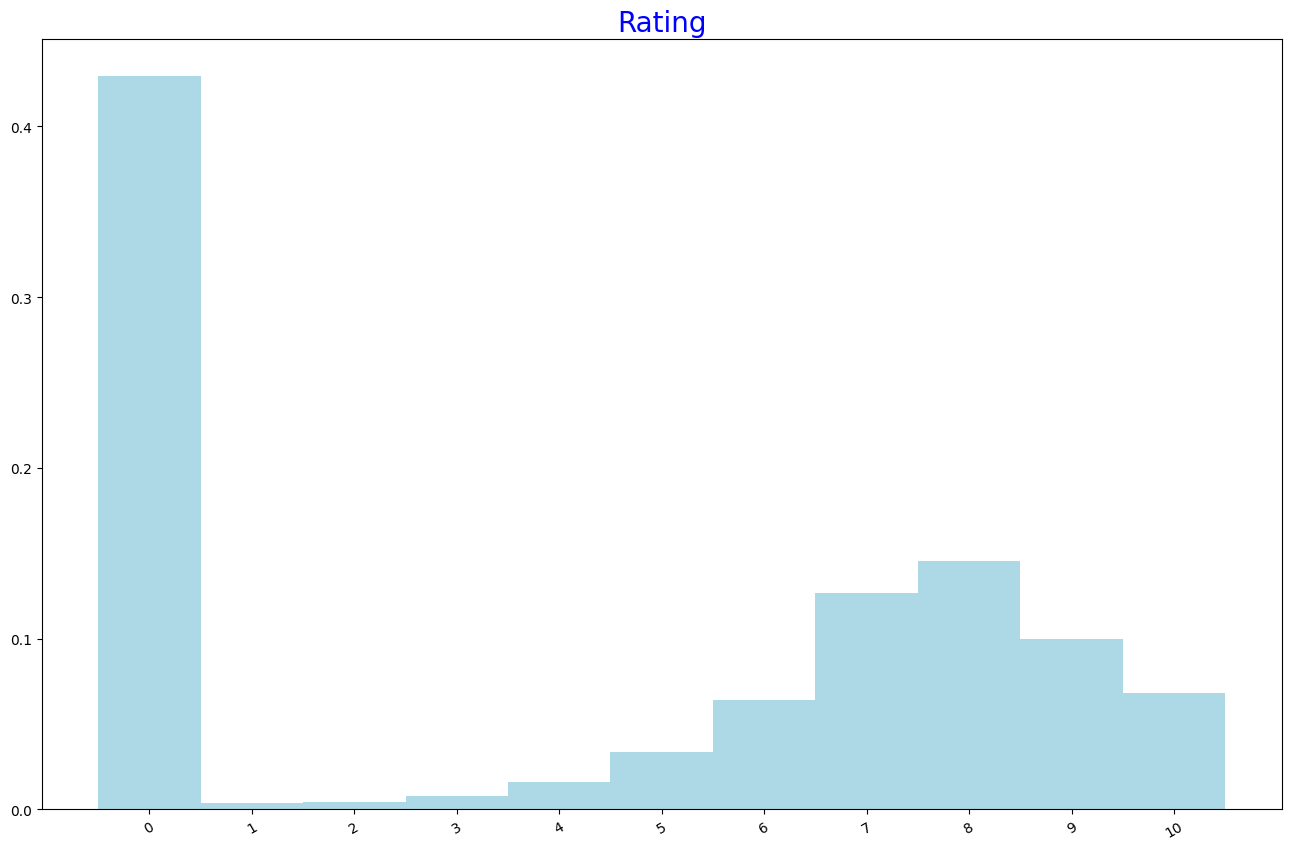

In [45]:
pos = np.arange(len(x_axis_sorted))
width = 1.0
plt.bar(pos, y_axis_sorted, width, color='lightblue')
plt.xticks(pos, x_axis_sorted, rotation=30)
fig = plt.gcf()
fig.set_size_inches(16, 10)
plt.title('Rating', fontsize=20, color='blue')
plt.show()

In [46]:
from pyspark.sql.functions import when, col
from pyspark.sql.types import StringType, IntegerType

def fill_null_values(df):
    string_columns = []  
    numeric_columns = [] 
    for column in df.columns:
        data_type = df.schema[column].dataType
        if isinstance(data_type, StringType):
            string_columns.append(column)
            
            df = df.withColumn(column, when(col(column).isNull() | (col(column) == ''), '0').otherwise(col(column)))
        elif isinstance(data_type, IntegerType):
            numeric_columns.append(column)
            
            df = df.withColumn(column, col(column).cast("int")).fillna(0)
    return df, string_columns, numeric_columns

son_data_filled, string_columns, numeric_columns = fill_null_values(son_data)


print("String column names:", string_columns)
print("Numeric column names:", numeric_columns)

String column names: ['Name', 'Score', 'Genres', 'Type', 'Episodes', 'Aired', 'Premiered', 'Source', 'Ranked', 'Popularity', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6', 'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1', 'Start_Year', 'End_Year', 'Premired Year']
Numeric column names: ['anime_id', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped', 'Plan to Watch', 'user_id', 'rating', 'watching_status', 'watched_episodes']


In [47]:
def convert_columns_to_numeric_and_fillna(df):
    string_columns = []  
    for column in df.columns:
        data_type = df.schema[column].dataType
        if isinstance(data_type, StringType):
            string_columns.append(column)
           
            df = df.withColumn(column, when(col(column).isNull() | (col(column) == ''), '0').otherwise(col(column)))
            df = df.withColumn(column, col(column).cast("int"))
        else:
           
            df = df.withColumn(column, col(column).cast("int")).fillna(0)
    return df, string_columns
son_data, string_columns = convert_columns_to_numeric_and_fillna(son_data)

print("\nChecking for null or empty values in 'son_data' after transformation:")
check_null_empty_values(son_data)

# String değerler içeren sütunların listesini yazdırın
print("String değerler içeren sütunlar:", string_columns)


Checking for null or empty values in 'son_data' after transformation:
Column 'anime_id' has no null or empty values.
Column 'Name' has no null or empty values.
Column 'Score' has no null or empty values.
Column 'Genres' has no null or empty values.
Column 'Type' has no null or empty values.
Column 'Episodes' has no null or empty values.
Column 'Aired' has no null or empty values.
Column 'Premiered' has no null or empty values.
Column 'Source' has no null or empty values.
Column 'Ranked' has no null or empty values.
Column 'Popularity' has no null or empty values.
Column 'Members' has no null or empty values.
Column 'Favorites' has no null or empty values.
Column 'Watching' has no null or empty values.
Column 'Completed' has no null or empty values.
Column 'On-Hold' has no null or empty values.
Column 'Dropped' has no null or empty values.
Column 'Plan to Watch' has no null or empty values.
Column 'Score-10' has no null or empty values.
Column 'Score-9' has no null or empty values.
Col

<h3 style="color: blue;">⚡️CheckPoint⚡️</h3>

In [48]:
import os

checkpoint_dir = "/path/to/local/checkpoint"

if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

In [49]:
import pyspark.sql

dataframe_names = [(name, var) for name, var in globals().items() if isinstance(var, pyspark.sql.DataFrame)]

for name, _ in dataframe_names:
    print(name)

anime_df
animelist_df
score_df
best_anime
popular_genres
animelist_df_first_10000
son_data
son_data_filled


In [50]:
for name, df in dataframe_names:
    df.write.format("parquet").mode("overwrite").save(f"{checkpoint_dir}/{name}")

In [51]:
from pyspark.rdd import RDD
rdd_names = [(name, var) for name, var in globals().items() if isinstance(var, RDD)]

for name, _ in rdd_names:
    print(name)

anime_rdd
anime_fields
type_rdd
type_counts
source_rdd
source_counts
animelist_rdd
animelist_data
animelist_fields
anime_list_rdd
anime_list_fields
rating_fields
ratings


In [ ]:
import shutil
import os

rdd_names = [(name, var) for name, var in globals().items() if isinstance(var, RDD)]
for name, rdd in rdd_names:
    path = f"{checkpoint_dir}/{name}_checkpoint"
    if os.path.exists(path):
        shutil.rmtree(path)
    rdd.saveAsTextFile(path)


<h1 style="font-size:30px; color:blue;"> 🌟 ALS🌟</h1>

In [6]:
rdd = sc.textFile("C:/Users/ilker/Desktop/Anime/animelist.csv")

In [7]:
header = rdd.first() 

In [8]:
data_rdd = rdd.filter(lambda line: line != header)

In [9]:
data_rdd.take(10)

['0,67,9,1,1',
 '0,6702,7,1,4',
 '0,242,10,1,4',
 '0,4898,0,1,1',
 '0,21,10,1,0',
 '0,24,9,1,5',
 '0,2104,0,1,4',
 '0,4722,8,1,4',
 '0,6098,6,1,2',
 '0,3125,9,1,29']

In [10]:
rating_fields = data_rdd.map(lambda line:line.split(','))
ratings_rdd = rating_fields.map(lambda field : int(field[2]))

In [11]:
ratings_rdd.stats()

(count: 109224747, mean: 4.245716641486047, stdev: 3.9128884433444586, max: 10.0, min: 0.0)

In [12]:
raw_rating = data_rdd.map(lambda x:x.split(',')[:3])
raw_rating.take(5)

[['0', '67', '9'],
 ['0', '6702', '7'],
 ['0', '242', '10'],
 ['0', '4898', '0'],
 ['0', '21', '10']]

In [13]:
from pyspark.mllib.recommendation import ALS
from pyspark.mllib.recommendation import Rating

ratingsforAls = raw_rating.map(lambda x: Rating(int(x[0]), int(x[1]), float(x[2])))
ratingsforAls.take(10)

[Rating(user=0, product=67, rating=9.0),
 Rating(user=0, product=6702, rating=7.0),
 Rating(user=0, product=242, rating=10.0),
 Rating(user=0, product=4898, rating=0.0),
 Rating(user=0, product=21, rating=10.0),
 Rating(user=0, product=24, rating=9.0),
 Rating(user=0, product=2104, rating=0.0),
 Rating(user=0, product=4722, rating=8.0),
 Rating(user=0, product=6098, rating=6.0),
 Rating(user=0, product=3125, rating=9.0)]

<h1 style="font-size:20px; color:#3498db;">🐏1GB🐏</h1>

In [14]:
"""
%%time
limited_ratings = ratingsforAls.take(58000000)
#57 million rows is approximately 1 GB
"""

CPU times: total: 1min 13s
Wall time: 4min 11s


In [14]:
%%time
limited_ratings = ratingsforAls.take(10000000)

CPU times: total: 8.36 s
Wall time: 35.1 s


In [15]:
%%time
limited_ratings_rdd = sc.parallelize(limited_ratings)

CPU times: total: 15.1 s
Wall time: 17.5 s


In [16]:
from pyspark.mllib.recommendation import ALS
from pyspark.mllib.evaluation import RegressionMetrics
from pyspark.sql import SparkSession
from pyspark.mllib.recommendation import Rating

In [17]:
train_data, test_data = limited_ratings_rdd.randomSplit([0.7, 0.3], seed=5066)

In [18]:
print(train_data.take(5))
print(test_data.take(5))

[Rating(user=0, product=67, rating=9.0), Rating(user=0, product=6702, rating=7.0), Rating(user=0, product=242, rating=10.0), Rating(user=0, product=21, rating=10.0), Rating(user=0, product=2104, rating=0.0)]
[Rating(user=0, product=4898, rating=0.0), Rating(user=0, product=24, rating=9.0), Rating(user=0, product=3125, rating=9.0), Rating(user=0, product=68, rating=6.0), Rating(user=0, product=1250, rating=7.0)]


In [19]:
from math import sqrt
#Models load
ranks = [10,15,20]
iterations = [10,15,20]
lambdas = [0.01,0.1]
models = []
evaluations = []

In [20]:
def anime_for_user(user: int):
    anime_for_user_rdd = limited_ratings_rdd.filter(lambda x: x.user == user)
    anime_for_user_list = anime_for_user_rdd.collect()
    for rating in anime_for_user_list[:10]:
        print(f"User: {rating.user}, Anime: {rating.product}, Rating: {rating.rating}")
    return anime_for_user_list

In [21]:
def cosineSimilarity(item_id, a, b):
    dot = np.dot(a,b)
    norma = np.linalg.norm(a)
    normb = np.linalg.norm(b)
    cos = dot/(norma * normb)
    return item_id, cos

In [22]:
%%time
import itertools

param_combinations = itertools.product(ranks, iterations, lambdas)
process_count = 0
for rank, iteration, lambda_ in param_combinations:
    model = ALS.train(train_data, rank=rank, iterations=iteration, lambda_=lambda_,seed=5066)
    process_count += 1
    item_id = 24
    item_vector = model.productFeatures().lookup(item_id)[0]
    print(f"\n Item vector for item_id {item_id}: {item_vector}")

    cosineSimilarity(item_id,item_vector,item_vector)

        
    predicted_rating = model.predict(0, 24)
    print(f"\n Predicted rating for user 0 and item 24: {predicted_rating}")

    userId = 0
    top_10_recs = model.recommendProducts(userId, 10)
    print(f"\n Top 10 recommendations for user {userId}:")
    for i in top_10_recs:
        print(i)
    
    top5_item = model.recommendUsers(24, 5)
    print(f"\n Top 5 users for item 24:")
    for i in top5_item:
        print(i)

    anime_for_userx = limited_ratings_rdd.keyBy(lambda x: x.user)
    print(anime_for_userx.take(10))

    animeForUser = anime_for_user(0)
    animeForUser.sort(reverse=True, key=lambda x: x.rating)
    
    print("\nTop 10 anime for user 0:")
    for rating in animeForUser[:10]:
        print(f" User: {rating.user}, Anime: {rating.product}, Rating: {rating.rating}")

    predictions = model.predictAll(test_data.map(lambda x: (x[0], x[1]))).map(lambda r: ((r[0], r[1]), r[2]))
    rates_and_preds = test_data.map(lambda r: ((int(r[0]), int(r[1])), float(r[2]))).join(predictions)
    
    print("Rates and Predictions (Sample):")
    print(rates_and_preds.take(10))

    predictions_list = predictions.collect()
    print("Predictions (Sample):")
    for rating in predictions_list:
        user_id, anime_id = rating[0]
        rating_value = rating[1]
        if user_id == 0:
            print(f" User: {user_id}, Anime: {anime_id}, Rating: {rating_value}")

    print("\nTest Data (Sample):")
    for rating in test_data.take(10):
        print(f" User: {rating.user}, Anime: {rating.product}, Rating: {rating.rating}")
    
    MSE = rates_and_preds.map(lambda tup: (tup[1][0] - tup[1][1]) ** 2).mean()
    RMSE = sqrt(MSE)
    print("Mean Squared Error (MSE) = ", MSE)
    print("Root Mean Squared Error (RMSE) = ", RMSE)

    evaluations.append(((rank, iteration, lambda_), MSE, RMSE))
    last_evaluation = evaluations[-1]
    print(f"\n Son eleman - Rank: {last_evaluation[0][0]}, Iteration: {last_evaluation[0][1]}, Lambda: {last_evaluation[0][2]}, MSE: {last_evaluation[1]}, RMSE: {last_evaluation[2]}")

    models.append((model, rank, iteration, lambda_))
    print(f"\n {process_count}. process is successful\n")


 Item vector for item_id 24: array('d', [-0.45050886273384094, 0.5134439468383789, -0.1632067859172821, 0.8264790177345276, 0.26409047842025757, -1.1386926174163818, -0.5240490436553955, 0.10144299268722534, 0.02503708004951477, -0.05589338764548302])

 Predicted rating for user 0 and item 24: 2.614560772170855

 Top 10 recommendations for user 0:
Rating(user=0, product=29291, rating=41.774433252583236)
Rating(user=0, product=44086, rating=38.944949962304925)
Rating(user=0, product=29936, rating=38.17166655893764)
Rating(user=0, product=6855, rating=35.80456239945434)
Rating(user=0, product=5002, rating=34.38761101203131)
Rating(user=0, product=33238, rating=33.78274720556394)
Rating(user=0, product=34115, rating=32.36392018157503)
Rating(user=0, product=10562, rating=32.17010733498465)
Rating(user=0, product=39204, rating=32.09720066913147)
Rating(user=0, product=42640, rating=31.421513489581343)

 Top 5 users for item 24:
Rating(user=26446, product=24, rating=21.14302610901221)
Rati

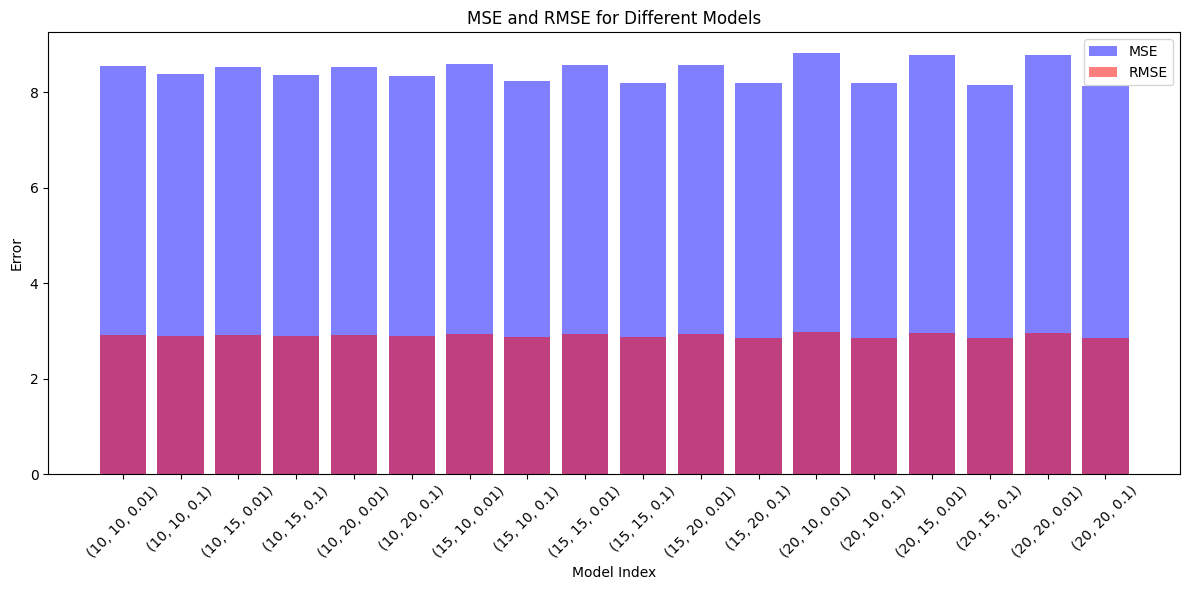

In [23]:
ranks_iterations_lambdas = [(params[0], params[1], params[2]) for params, mse, rmse in evaluations]
mses = [mse for params, mse, rmse in evaluations]
rmses = [rmse for params, mse, rmse in evaluations]

plt.figure(figsize=(12, 6))
plt.bar(range(len(evaluations)), mses, color='b', alpha=0.5, label='MSE')
plt.bar(range(len(evaluations)), rmses, color='r', alpha=0.5, label='RMSE')
plt.xlabel('Model Index')
plt.ylabel('Error')
plt.title('MSE and RMSE for Different Models')
plt.xticks(range(len(evaluations)), ranks_iterations_lambdas, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [24]:
best_model_info = min(evaluations, key=lambda x: x[2])
print("Best Model:", best_model_info)
best_model_params = best_model_info[0]
best_model = ALS.train(train_data, rank=best_model_params[0], iterations=best_model_params[1], lambda_=best_model_params[2])

Best Model: ((20, 20, 0.1), 8.143839056066907, 2.853741238456442)


In [25]:
new_item_id = 24
new_item_vector = best_model.productFeatures().lookup(item_id)[0]
new_item_vector

array('d', [0.21108445525169373, -0.688731849193573, -0.1417933702468872, -1.086441159248352, 0.6083396077156067, -0.9333931803703308, -0.06241092458367348, -1.0376697778701782, -1.2499043941497803, -0.19543635845184326, 0.6239340305328369, -0.1653013825416565, -0.4606398642063141, 0.3790259063243866, -0.25339534878730774, 0.0700823962688446, 0.16330190002918243, 0.19273671507835388, 0.13674099743366241, -1.5032151937484741])

In [26]:
similarities = best_model.productFeatures().map(lambda data: cosineSimilarity(data[0], data[1], new_item_vector))

In [27]:
similarities.top(10, key=lambda x:x[1])

[(24, 1.0),
 (846, 0.9069885760931016),
 (189, 0.8953390721600908),
 (240, 0.8581713119686123),
 (32789, 0.8547494832941839),
 (50, 0.8516484289916543),
 (248, 0.8516137966648346),
 (59, 0.8400481319763428),
 (880, 0.8349690582533744),
 (71, 0.8333111986267631)]

<h1 style="font-size:30px; color:#3498db;">🎉🎉🎉🎉🎉🎉🎉</h1>